In [1]:
import synapseclient
import pandas as pd
import json
import csv

In [2]:
def TapPerformance(TapPD1):
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonLeft', 'TappedButtonId'] = 0
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonRight', 'TappedButtonId'] = 1
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonNone', 'TappedButtonId'] = 2
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonLeft'] = 0
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonRight'] = 1
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonNone'] = 2
    TapPD1 = Artifactfixed(TapPD1)
    TapPerf= TapPD1.shape[0]
    return (TapPerf)

In [3]:
#def ConvertTypePatient(MedTime):
#    if (MedTime == "I don't take Parkinson medications"):
#        ClassPD = 0
#    elif (MedTime == "Immediately before Parkinson medication"):
#        ClassPD = 1
#    elif (MedTime == "Just after Parkinson medication (at your best)"):
#        ClassPD =2
#    else (MedTime == "Another time"):
#        ClassPD =3

In [4]:
#Index=list()
def Artifactfixed(TapCont):
    Ind =  [True] * TapCont.shape[0]
    for item in range(0,TapCont.shape[0]-1):
        if TapCont.TapCoordinate[item]==TapCont.TapCoordinate[item+1]:
            if TapCont.TappedButtonId[item]==2:
                Ind[item]=False
            elif TapCont.TappedButtonId[item+1]==2:
                Ind[item]=False
    TapContArtFixed=TapCont[Ind]
    return TapContArtFixed
          

In [5]:

syn = synapseclient.Synapse()
syn.login('catarivera8', 'Crm1061709701')


## QUERY THE mPower PROJECT (syn4993293) FOR ALL OF THE TABLES
# See examples: https://python-docs.synapse.org/build/html/index.html 
# and https://www.synapse.org/#!Synapse:syn4993293/discussion/threadId=6785
with open('TappingTable.csv') as csvfile:
    TapTable=pd.read_csv(csvfile, delimiter=',')
with open('DemoTable.csv') as csvfile:
    DemoTable=pd.read_csv(csvfile, delimiter=',') 
#Using Patient column (healthCode) as index for the Data frames
#TapTableB = TapTable.set_index("healthCode", drop = False) 
#DemoTableB = DemoTable.set_index("healthCode", drop = False)    

      
#TapPD = list()
PathList = list()
LabelList = list()
#PatientType = list()
#PatientList = list()
#AgeList = list()
Perform =list()
for offset in range(0,10000,100):
    results = syn.tableQuery('SELECT * FROM syn5511439 LIMIT 100 OFFSET '+str(offset))
    file_map=syn.downloadTableColumns(results,['tapping_results.json.TappingSamples'])
    for file_handle_id, path in file_map.items():
        #TapPD.append(pd.read_json(path))
        PathList.append(path)
        LabelList.append(int(file_handle_id))
        #PatientType.append(TapTableB['medTimepoint'][TapTable['tapping_results.json.TappingSamples'] == int(file_handle_id)])
        Perform.append(TapPerformance(pd.read_json(path))) #Tap performance
        #PatientList.append(TapTableB['healthCode'][TapTableB['tapping_results.json.TappingSamples'] == int(file_handle_id)])
        #DemoTableB.loc[(TapTableB['healthCode'][TapTableB['tapping_results.json.TappingSamples'] == int(file_handle_id)]),"age"]
        

Welcome, Catalina Rivera!



## Building data frame using tapping performance and demographic information

In [6]:
#Creating directory
d = {'tapping_results.json.TappingSamples':LabelList,'TapPerform':Perform}
PerfInfo = pd.DataFrame(d)
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
#TapTable=TapTable.merge(PerfInfo,left_on='tapping_results.json.TappingSamples', right_on='tapping_results.json.TappingSamples')
TapTable=TapTable.merge(PerfInfo)
#Sub-DataFrame of Demo Table with only features of interest: Age, diagnostic year, gender.
#DemoTable.head()
DemoTableN=DemoTable[["age","healthCode","diagnosis-year","gender"]]
DemoTableN.shape
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
TapTableN=TapTable.merge(DemoTableN)
#Check for NAN and replacing them
TapTableN['diagnosis-year'] = TapTableN['diagnosis-year'].fillna(0)
#Check for NAN in age column and drop it.
TapTableN.dropna(subset = ["age"], inplace=True)


In [7]:
# change gender column to categorical 0:female, 1: male
df_gender = pd.get_dummies(TapTableN['gender'],drop_first=True)
#print(TapTableN.gender.value_counts())
TapTableN = pd.concat([TapTableN, df_gender], axis=1)
TapTableN.head()
#df.Embarked.value_counts()
#df = pd.get_dummies(df, columns=['Sex', 'Embarked'])
#pd.get_dummies(df.Sex, drop_first=True)


,ROW_ID,ROW_VERSION,recordId,healthCode,createdOn,appVersion,phoneInfo,accel_tapping.json.items,tapping_results.json.ButtonRectLeft,tapping_results.json.ButtonRectRight,...,tapping_results.json.startDate,tapping_results.json.TappingSamples,tapping_results.json.TappingViewSize,medTimepoint,TapPerform,age,diagnosis-year,gender,Male,Prefer not to answer
0,82315,18,caf7a74b-0d2e-4c43-9233-ed5dc6e7b176,639e8a78-3631-4231-bda1-c911c1b169e5,1.425900e+12,"version 1.0, build 7",iPhone 6,5395782.0,"{{0, 191.5}, {104, 104}}","{{128, 191.5}, {104, 104}}",...,1.425900e+12,5395798.0,"{375, 603}",I don't take Parkinson medications,294,24.0,0.0,Male,1,0
1,82316,18,94c95572-b405-49ca-9eb0-7426254990d5,52fe366a-2a9f-4260-9fb1-0fbc637a6cf4,1.425930e+12,"version 1.0, build 7",iPhone 5s (GSM),5403976.0,"{{0, 156.5}, {104, 104}}","{{128, 156.5}, {104, 104}}",...,1.425930e+12,5403991.0,"{320, 504}",I don't take Parkinson medications,289,38.0,0.0,Female,0,0
2,88685,19,6e5f5d0f-745c-4f0d-b210-829f1490a37f,52fe366a-2a9f-4260-9fb1-0fbc637a6cf4,1.426020e+12,"version 1.0, build 7",iPhone 5s (GSM),5471683.0,"{{0, 156.5}, {104, 104}}","{{128, 156.5}, {104, 104}}",...,1.426020e+12,5471839.0,"{320, 504}",I don't take Parkinson medications,374,38.0,0.0,Female,0,0
3,82317,18,ebd99144-5b84-486e-818c-5f8daf8beebf,67bdd316-26fc-4fc7-8431-bf9f41a649dd,1.425930e+12,"version 1.0, build 7",iPhone 6 Plus,5397281.0,"{{0, 191.33333333333331}, {104, 104}}","{{128, 191.33333333333331}, {104, 104}}",...,1.425930e+12,5397298.0,"{414, 672}",I don't take Parkinson medications,164,32.0,0.0,Male,1,0
4,82318,18,8e32cff2-c8f9-4047-af57-411a98fc9116,67bdd316-26fc-4fc7-8431-bf9f41a649dd,1.425930e+12,"version 1.0, build 7",iPhone 6 Plus,5395191.0,"{{0, 191.33333333333331}, {104, 104}}","{{128, 191.33333333333331}, {104, 104}}",...,1.425930e+12,5395211.0,"{414, 672}",I don't take Parkinson medications,229,32.0,0.0,Male,1,0


## Building the model

Number of persons with the disease is: 1286.00
Number of persons total: 8697.00
Accuracy of logistic regression classifier on test set: 0.91
[[2153   84]
 [ 155  218]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      2237
         1.0       0.72      0.58      0.65       373

    accuracy                           0.91      2610
   macro avg       0.83      0.77      0.80      2610
weighted avg       0.90      0.91      0.90      2610



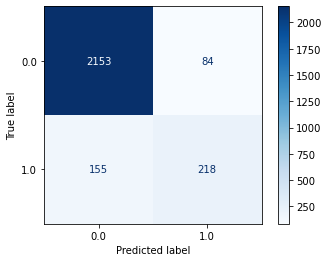

In [19]:
# Classification for each quantile
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt



X = TapTableN[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
#XTapPerf = np.reshape(XTapPerf, (-1,1))
TapTableN['PDOn']= TapTableN['diagnosis-year']
Y=TapTableN['PDOn'].to_numpy()
Y[Y!=0] = 1
print('Number of persons with the disease is: {:.2f}'.format(np.sum(Y)))
print('Number of persons total: {:.2f}'.format(len(Y)))
#array_sum = np.sum(X)
#array_has_nan = np.isnan(array_sum)
#print(array_has_nan)

X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.3, random_state=0)

#print(X)
#print(Y)
#print(y_train.shape)


#Training logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)
print(classification_report(y_test, y_pred))
disp = plot_confusion_matrix(logreg, X_test, y_test,cmap=plt.cm.Blues)


#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

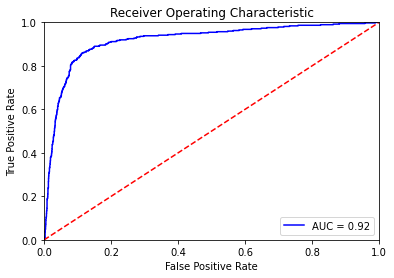

0.16627051778186974
0.8579088471849866
0.11175681716584712


In [27]:
#Plotting ROC Curve

#Calculate probabilities. Notice that this is different than evaluating the predict y_pred
y_prob = logreg.predict_proba(X_test)
y_prob1 = y_prob[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob1)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Finding the best threshold
print(threshold[np.argmax(tpr - fpr)])
print(tpr[np.argmax(tpr - fpr)])
print(fpr[np.argmax(tpr - fpr)])

## Using only people before taking medication


Accuracy of logistic regression classifier on test set: 0.94
[[2191   38]
 [  96   44]]
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2229
         1.0       0.54      0.31      0.40       140

    accuracy                           0.94      2369
   macro avg       0.75      0.65      0.68      2369
weighted avg       0.93      0.94      0.94      2369



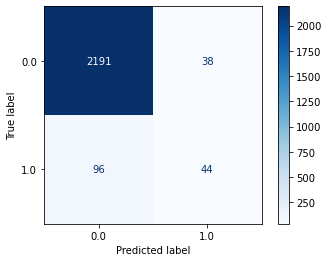

In [16]:
TapTableB = TapTableN[TapTableN['medTimepoint'] != "Just after Parkinson medication (at your best)"] 
TapTableC = TapTableB[TapTableB['medTimepoint'] != "Another time"] 

XX = TapTableC[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
YY=TapTableC['PDOn'].to_numpy()
YY[YY!=0] = 1

XX_train, XX_test, yy_train, yy_test = train_test_split(XX,YY , test_size=0.3, random_state=1)

#Training logistic regression
logregC = LogisticRegression()
logregC.fit(XX_train, yy_train)
yy_predC = logregC.predict(XX_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregC.score(XX_test, yy_test)))
confusionMatrixC = confusion_matrix(yy_test, yy_predC)
print(confusionMatrixC)
print(classification_report(yy_test, yy_predC))
dispC = plot_confusion_matrix(logregC, XX_test, yy_test,cmap=plt.cm.Blues)



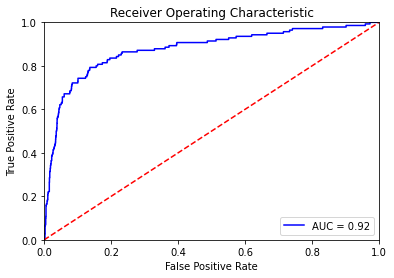

In [17]:
#Plotting ROC Curve

#Calculate probabilities. Notice that this is different than evaluating the predict y_pred
y_probC = logregC.predict_proba(XX_test)
y_prob1C = y_probC[:, 1]

fprC, tprC, thresholdC = metrics.roc_curve(yy_test, y_prob1C)
roc_aucC = metrics.auc(fprC, tprC)

plt.title('Receiver Operating Characteristic')
plt.plot(fprC, tprC, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#Saving this for using the new threshold
#y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3
#print(fprC)
#print(fpr)

## Graph to see time dependency

[WARNING] <ipython-input-35-542d9e297eb3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  YearsPD[Ind]=(2015-YearsPD[Ind])



0.016125089195343046
0.0


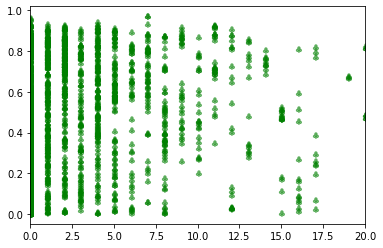

In [35]:
Prob = logreg.predict_proba(X)
ProbOfPD=Prob[:, 1]
Ind=(TapTableN["diagnosis-year"]!=0)
YearsPD=TapTableN["diagnosis-year"]
nd=(YearsPD!=0)
YearsPD[Ind]=(2015-YearsPD[Ind])
plt.scatter(YearsPD, ProbOfPD, c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")
plt.xlim([0, 20])
print(ProbOfPD[42])
print(YearsPD[42])
#TapTableN["TimeDis"][Ind]=(2015-TapTableN["diagnosis-year"][Ind])
#print(TapTableN["age"][72])

## Classifying using diagnostic year as starting point of the disease

0.25    2.0
0.50    4.0
0.75    7.0
Name: diagnosis-year, dtype: float64


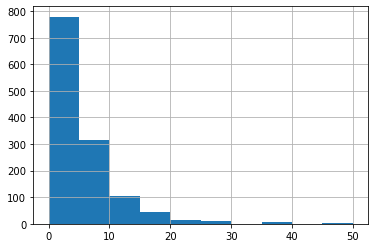

In [13]:
#Let us look at a histogram of the diagnosis year and find quantiles


Bol=TapTableN["diagnosis-year"]!=0 
Diagnosis=TapTableN["diagnosis-year"][Bol]
Bol2=Diagnosis>1960
Diagnosis= 2015-Diagnosis[Bol2]
#print(Diagnosis)
hist = Diagnosis.hist(bins=10)
YearsDiaQuant=Diagnosis.quantile([.25, .5, 0.75])

##Drop values were diagnosis year does not make sense
#Diagnosis = Diagnosis[Diagnosis > 15]
print(YearsDiaQuant)




## Classifier for first quantile

In [14]:
#Ind=(TapTableN["diagnosis-year"]!=0)
#TapTableN["TimeDis"]=TapTableN["diagnosis-year"]
##C=(2015-TapTableN["diagnosis-year"][Ind])
#TapTableN["TimeDis"][Ind]=(2015-TapTableN["diagnosis-year"][Ind])

#print(TapTableN["TimeDis"])
##TapTableN['TimeWithPD']= TapTableN['diagnosis-year']


In [15]:
#YearsDiaQuant=Diagnosis.quantile([.25, .5, 0.75])
#print(YearsDiaQuant)
#ListQ=YearsDiaQuant.to_list
#ListQ[[1]]



